# Convolutional Neural Network (1of1)

**Notes about this specific notebook**

Uses rgb, 64x64 images with ReLU activation and Adam optimizer.

# Changeable Parameters

_____________________________________________________________________

In [1]:
# Image size (height x width)
ih = 64
iw = 64

# Grayscale or RGB
ch = 'grayscale'

# Batch size
batch_size = 40000

# Number of epochs
epoch_t = 25

# Where computation is performed: Kaggle (0) or Local (1)
cenv = 1

# Division of the training vs. test set 
test_size = 0.3

_____________________________________________________________________

In [2]:
# To check whether the right environment has been selected
if cenv == 0:
    print("Computation environment: Kaggle")
if cenv == 1:
    print("Computation environment: Local")

Computation environment: Local


Import the necessary libraries

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import tensorflow as tf
import numpy as np
from sklearn.utils import class_weight
from sklearn import metrics
import sys
import os
from math import log
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Check whether a, and which GPU is available for the computation

In [4]:
is_cuda_gpu_available = tf.config.list_physical_devices('GPU')
print(is_cuda_gpu_available)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
# Image size
im_si = (ih, iw)

# Convert the color channel to the corresponding number of layers
if(ch == 'rgb'):
    chnum = 3
elif(ch == 'grayscale'):
    chnum = 1

Create new directory for saving output files if computation is done locally

In [6]:
if cenv == 1:
    file_exists = []
    vnum = 1
    dir = "C:/Users/Max/Documents/GitHub/malimg_dataset"
    for files in os.listdir(dir):
        if "cnn" in files:
            try:
                vnum = max(vnum, int(files[-3:]))
            except: 
                continue
            new_vnum = vnum + 1
            file_exists.append(True)
        else: 
            file_exists.append(False)
    # If this is the first notebook you want to save, a new folder will be created with version #001
    if sum(file_exists) == 0:
        new_vnum = 1
        print("No matches found")

    else: 
        print(f"{sum(file_exists)} matches(es) found")
        print("--------------")

    # Print new folder name
    print(f"New folder name: cnn-local-v{new_vnum:03}")
    print("--------------")
    
    # Create new folder with the name of the notebook and the version number
    new_dir = f"/Users/Max/Documents/GitHub/malimg_dataset/cnn-local-v{new_vnum:03}"
    os.makedirs(new_dir)

7 matches(es) found
--------------
New folder name: cnn-local-v007
--------------


**Data**


In [7]:
if cenv == 0:
    path_root = "/kaggle/input/thesis-data"

if cenv == 1:
    path_root = "C:/Users/Max/Documents/image_data/malimg_paper_dataset_imgs"

Load the data. No data augmentation takes place

In [8]:
batches = ImageDataGenerator().flow_from_directory(
    directory     = path_root, 
    color_mode    = ch, 
    target_size   = (ih,iw), 
    batch_size    = batch_size,
    interpolation = 'bicubic'
)
imgs, labels = next(batches)

Found 9339 images belonging to 25 classes.


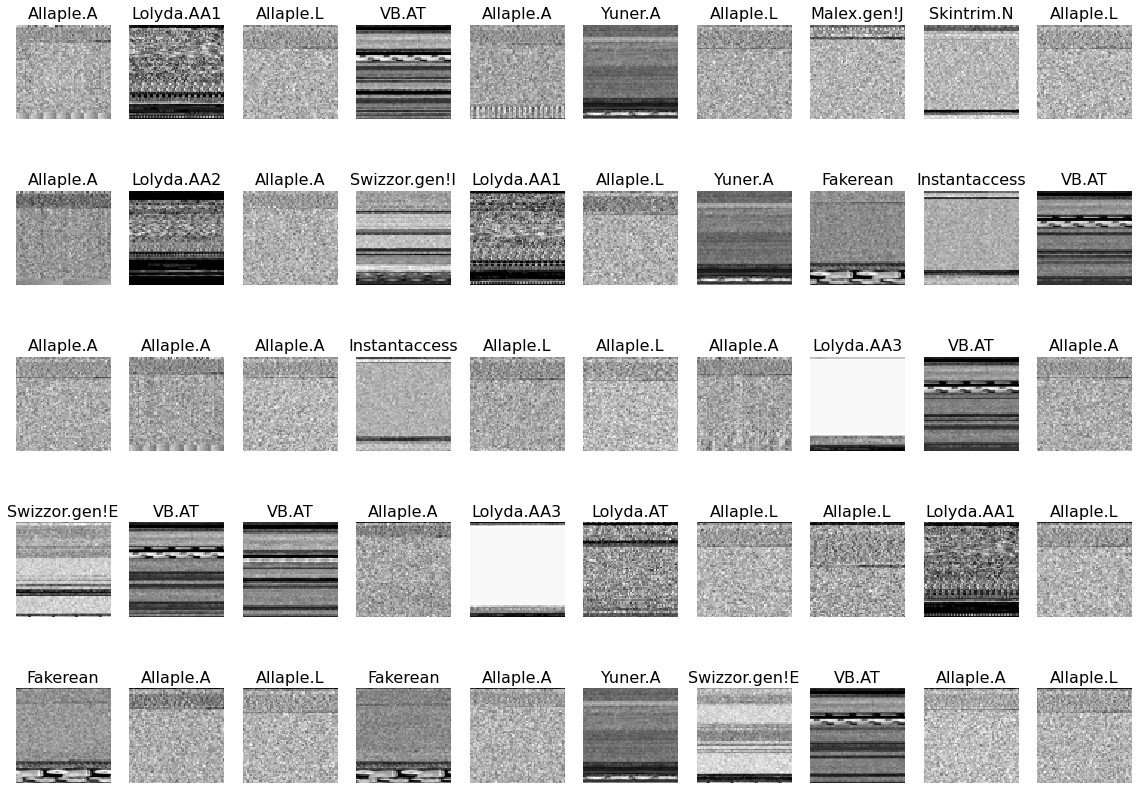

In [9]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != chnum):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(batches.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], cmap = 'gray',interpolation=None if interp else 'none')
        
plots(imgs, titles = labels)

In [10]:
# A dictionary of all the different classes
classes = batches.class_indices.keys()

Plot data distribution among all classes

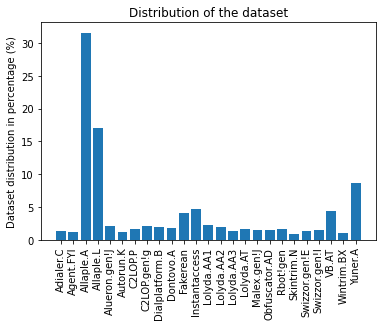

In [11]:
perc = (sum(labels)/labels.shape[0])*100
plt.xticks(rotation='vertical')
plt.bar(classes,perc)
plt.title('Distribution of the dataset')
plt.ylabel('Dataset distribution in percentage (%)')

if cenv == 0:
    plt.savefig("multi_data_dist.png", bbox_inches = 'tight', dpi = 150)
if cenv == 1:
    plt.savefig(f"{new_dir}/multi_data_dist.png", bbox_inches = 'tight', dpi = 150)

Split the data into train and test/val set using chosen split (70-30 in this case). Then separate the test/val split into validation and test set using 0.5 split. This leads to 70-15-15 split

In [12]:
# Train and Test
X_train, X_test, y_train, y_test = train_test_split(imgs/255.,labels, test_size=test_size)

X_test, X_val, y_test, y_val =  train_test_split(X_test, y_test, test_size=0.5)

In [13]:
X_train_size = len(X_train)
X_test_size = len(X_test)
X_val_size = len(X_val)

print(f"Size of training data: {X_train_size} | Shape of training data {X_train.shape}")
print(f"Size of test data: {X_test_size}  | Shape of test data {X_test.shape}")
print(f"Size of training data: {X_val_size}  | Shape of training data {X_val.shape}")
print(f"Shape of training labels {y_train.shape}")
print(f"Shape of training labels {y_test.shape}")

Size of training data: 6537 | Shape of training data (6537, 64, 64, 1)
Size of test data: 1401  | Shape of test data (1401, 64, 64, 1)
Size of training data: 1401  | Shape of training data (1401, 64, 64, 1)
Shape of training labels (6537, 25)
Shape of training labels (1401, 25)


Plot data distribution among train, val. and test set

In [14]:
def my_fmt(x):
    return '{:.1f}%\n({:.0f})'.format(x, total*x/100)
total = X_train_size + X_test_size + X_val_size

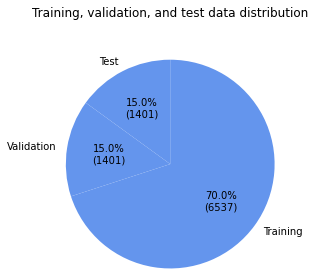

In [15]:
patches, texts, autotexts = plt.pie(
    [X_train_size, X_val_size, X_test_size], 
    labels = ["Training", "Validation", "Test"], 
    startangle=90, 
    counterclock=False, 
    autopct=my_fmt,
    colors = ['cornflowerblue', 'cornflowerblue', 'cornflowerblue'],
    radius=1.2
)

plt.title("Training, validation, and test data distribution", y = 1.15)

if cenv == 0:
    plt.savefig("train_test_dist.png", bbox_inches = 'tight', dpi = 150)
if cenv == 1:
    plt.savefig(f"{new_dir}/train_test_dist.png", bbox_inches = 'tight', dpi = 150)

# Convolutional Neural Network
We will now build our **CNN** model using Keras. This model will have the following layers :

* **Convolutional Layer** : 30 filters, (3 * 3) kernel size
* **Max Pooling Layer** : (2 * 2) pool size
* **Convolutional Layer** : 15 filters, (3 * 3) kernel size
* **Max Pooling Layer** : (2 * 2) pool size
* **DropOut Layer** : Dropping 25% of neurons.
* **Flatten Layer**
* **Dense/Fully Connected Layer** : 128 Neurons, ReLU activation function
* **DropOut Layer** : Dropping 50% of neurons.
* **Dense/Fully Connected Layer** : 50 Neurons, Softmax activation function
* **Dense/Fully Connected Layer** : num_class Neurons, Softmax activation function

**Input shape** : 64 * 64 * 1

In [16]:
import keras
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

We want **11** classes

In [17]:
num_classes = len(list(batches.class_indices))
print("The number of classes in our dataset: ", num_classes)

The number of classes in our dataset:  25


Building the model

In [18]:
def malware_model():
    Malware_model = Sequential()
    Malware_model.add(Conv2D(30, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(ih,iw,chnum)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(15, (3, 3), activation='relu'))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Dropout(0.25))
    Malware_model.add(Flatten())
    Malware_model.add(Dense(128, activation='relu'))
    Malware_model.add(Dropout(0.5))
    Malware_model.add(Dense(50, activation='relu'))
    Malware_model.add(Dense(num_classes, activation='softmax'))
    Malware_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return Malware_model

Compiling and showing overview of the model

In [19]:
Malware_model = malware_model()
Malware_model.summary() # Overview of the CNN model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 30)        300       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 30)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 15)        4065      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 15)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 15)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2940)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               3

Reduce learning rate after 5 epochs of no improvement on the validition accuracy. Also save save checkpoints for the best performing model based on validation loss

In [20]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-4)
if cenv == 0:
    checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
if cenv == 1:
    checkpoint = ModelCheckpoint(f'{new_dir}/model.h5', verbose=1, save_best_only=True)


Run the model

In [21]:
history = Malware_model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=epoch_t,
    callbacks = [anne, checkpoint]) # The actual computation of the CNN

Epoch 1/25
205/205 [==============================] - 4s 8ms/step - loss: 1.8106 - accuracy: 0.4620 - val_loss: 0.6805 - val_accuracy: 0.8208

Epoch 00001: val_loss improved from inf to 0.68051, saving model to /Users/Max/Documents/GitHub/malimg_dataset/cnn-local-v007\model.h5
Epoch 2/25
205/205 [==============================] - 1s 7ms/step - loss: 0.5896 - accuracy: 0.8229 - val_loss: 0.2267 - val_accuracy: 0.9329

Epoch 00002: val_loss improved from 0.68051 to 0.22675, saving model to /Users/Max/Documents/GitHub/malimg_dataset/cnn-local-v007\model.h5
Epoch 3/25
205/205 [==============================] - 1s 7ms/step - loss: 0.3462 - accuracy: 0.8972 - val_loss: 0.2000 - val_accuracy: 0.9429

Epoch 00003: val_loss improved from 0.22675 to 0.19999, saving model to /Users/Max/Documents/GitHub/malimg_dataset/cnn-local-v007\model.h5
Epoch 4/25
205/205 [==============================] - 1s 7ms/step - loss: 0.2765 - accuracy: 0.9154 - val_loss: 0.1713 - val_accuracy: 0.9522

Epoch 00004: va

# Evaluating performance

In [22]:
from sklearn.metrics import f1_score, matthews_corrcoef, accuracy_score
from prettytable import PrettyTable, MSWORD_FRIENDLY

Load the best performing model. N.B. the best performing model did so on the validation set. The model has never seen the test set at this point

In [23]:
if cenv == 0:
    best_model = load_model("/kaggle/working/model.h5")
if cenv == 1:
    best_model = load_model(f"{new_dir}/model.h5")

Evaluate the model based on the test set

In [24]:
scores = best_model.evaluate(X_test, y_test) # Testing the CNN on the test set
print(f"Overall CNN Accuracy: {scores[1]}\n(The number of correct predictions divided by the number of total predictions)")

44/44 [==============================] - 0s 3ms/step - loss: 0.0718 - accuracy: 0.9772
Overall CNN Accuracy: 0.9771591424942017
(The number of correct predictions divided by the number of total predictions)


Save a table with the performance on the test set

In [25]:
t = PrettyTable(['Metric', 'Performance'])
t.add_row(['Valididation accuracy', round(scores[1],4)])
t.add_row(['Validation loss', round(scores[0],4)])
t.header = True
t.align = "l"
t.title = "Performance of multi-class classification - CNN"
print(t)

+-------------------------------------------------+
| Performance of multi-class classification - CNN |
+-------------------------------+-----------------+
| Metric                        | Performance     |
+-------------------------------+-----------------+
| Valididation accuracy         | 0.9772          |
| Validation loss               | 0.0718          |
+-------------------------------+-----------------+


In [26]:
# Saving PrettyTable
table = t.get_string()

if cenv == 0:
    with open('multi_performance_table.txt', 'w') as f:
        f.write(table)
if cenv == 1:
    with open(f'{new_dir}/multi_performance_table.txt', 'w') as f:
        f.write(table)

# Evaluating overfitting and other model performance measures

In [27]:
def eval_metric(model, history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]
    e = range(1, epoch_t + 1)
    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_name)
    plt.title('Comparing training and validation ' + metric_name + ' for ' + model.name)
    plt.legend()
    if cenv == 0:
        plt.savefig(f"cnn_model_{metric_name}.png", bbox_inches = 'tight', dpi = 150)
    if cenv == 1:
        plt.savefig(f"{new_dir}/cnn_model_{metric_name}.png", bbox_inches = 'tight', dpi = 150)

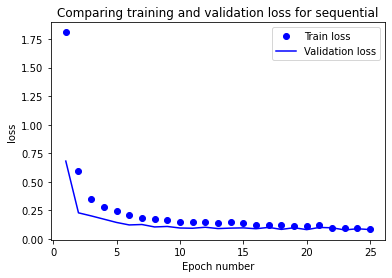

In [28]:
eval_metric(Malware_model, history, 'loss')

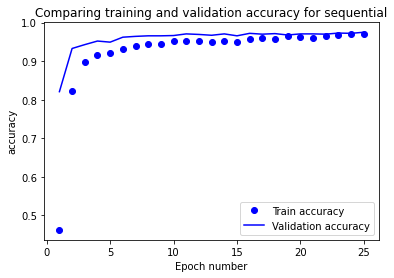

In [29]:
eval_metric(Malware_model, history, 'accuracy')

# Confusion Matrix
Analysing the results

In [30]:
# Create two 1D-arrays: one with the prediction per image of the model and one with the true labels
y_pred = np.argmax(Malware_model.predict(X_test), axis=-1)
y_test2 = np.argmax(y_test, axis=1)

Create confusion matrix for the multi-class classification

In [31]:
c_matrix = metrics.confusion_matrix(y_test2, y_pred)
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
   
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if cenv == 0:
        plt.savefig("multi_class_cmatrix.png", bbox_inches = 'tight', dpi = 150)
    if cenv == 1:
        plt.savefig(f"{new_dir}/multi_class_cmatrix.png", bbox_inches = 'tight', dpi = 150)

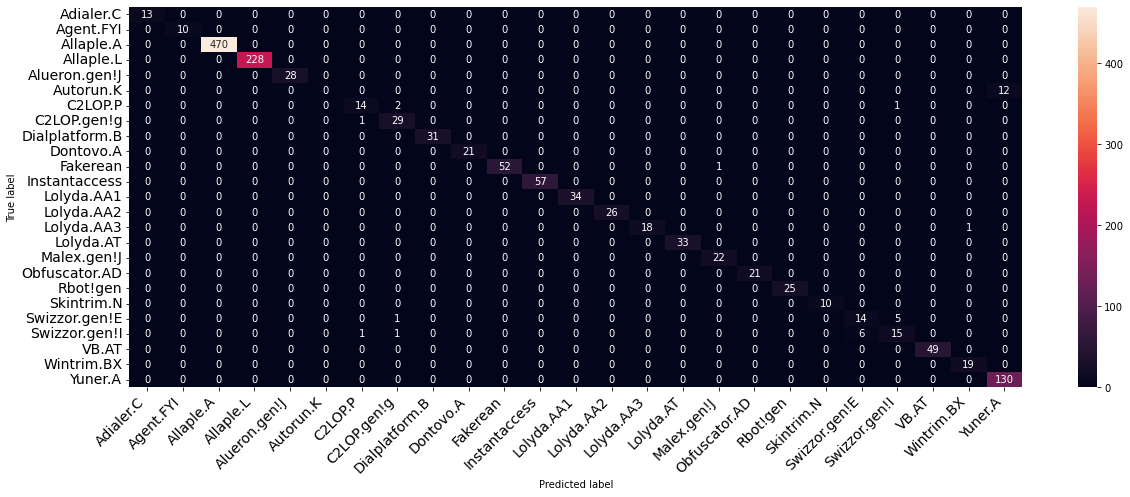

In [32]:
class_names= batches.class_indices.keys()
confusion_matrix(c_matrix, class_names, figsize = (20,7), fontsize=14)